In [2]:
from ipynb.fs.full.TARGET_Analysis_Functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [3]:
# Read in sample z-score data from 'data_mRNA_median_all_sample_Zscores.txt' into pandas dataframe
z_scores = pd.read_csv('../nbl_target_2018_pub/data_mRNA_median_all_sample_Zscores.txt',  sep='\t')

#Find z-scores for ACE2 gene
ACE2_z_scores = z_scores.loc[z_scores['Hugo_Symbol']=='ACE2'].iloc[:,2:].transpose()
ACE2_z_scores.reset_index(inplace=True)
ACE2_z_scores = ACE2_z_scores.rename(columns = {'index':'Sample Identifier'})
ACE2_z_scores = ACE2_z_scores.rename(columns = {144:'ACE2 z-score'})

#Read in patient and sample clinical data into pandas dataframe
clinical_patient = pd.read_csv('../nbl_target_2018_pub/data_clinical_patient.txt',  sep='\t', error_bad_lines=False)
clinical_sample = pd.read_csv('../nbl_target_2018_pub/data_clinical_sample.txt',  sep='\t', error_bad_lines=False)

#Trim patient and sample clinical data to get rid of extraneous headers
clinical_patient_trimmed = clinical_patient.iloc[4:,:]
clinical_sample_trimmed = clinical_sample.iloc[4:,:]



In [4]:
#Merge clinical patient, sample, and ACE2 z-score data
merged_df = clinical_sample_trimmed.merge(ACE2_z_scores, on='Sample Identifier')
merged_df = clinical_patient_trimmed.merge(merged_df, on='#Patient Identifier')

In [5]:
merged_df

,#Patient Identifier,Protocol,ICDO,SNOMED,ICDO Snomed Description,Diagnosis Age (days),Diagnosis Age,Year of Diagnosis,INSS Stage,Tumor Sample Histology,...,MKI,Oncotree Code,Analysis Cohort,Tumor Disease Anatomic Site,CNS Site of Relapse,Tumor Ploidy,Cancer Type,Cancer Type Detailed,Somatic Status,ACE2 z-score
0,TARGET-30-PADIRB,"3891, B003, B954, E18",Unknown,999,Right sided Abdominal adrenal tumor -no intras...,1191,4,1992,Stage 4,Unfavorable,...,Low,NBL,DISCOVERY,NaN,NaN,NaN,Peripheral Nervous System,Neuroblastoma,Matched,1.7184
1,TARGET-30-PAKGCI,"9047, P9641",C74.9,999,"Adrenal gland, NOS Suprarenal gland Adrenal, NOS",300,1,2000,Stage 1,Favorable,...,Unknown,NBL,DISCOVERY,NaN,NaN,1.5,Peripheral Nervous System,Neuroblastoma,Matched,0.2901
2,TARGET-30-PAIXLC,"9047, P9641",C38.3,999,"Mediastinum, NOS",270,1,2000,Stage 1,Favorable,...,Intermediate,NBL,DISCOVERY,NaN,NaN,1.94,Peripheral Nervous System,Neuroblastoma,Matched,-1.2016
3,TARGET-30-PAISNS,"9047, P9462",Unknown,93,ADRENAL GLAND,1070,3,1998,Stage 4,Unknown,...,Unknown,NBL,DISCOVERY,NaN,NaN,1,Peripheral Nervous System,Neuroblastoma,Matched,-0.2802
4,TARGET-30-PACSNL,"321P2, B003, S31, B954",Unknown,999,Metastatic NBL,2157,6,1988,Stage 4,Unfavorable,...,Unknown,NBL,DISCOVERY,NaN,NaN,NaN,Peripheral Nervous System,Neuroblastoma,Matched,1.4535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,TARGET-30-PADPRJ,"3891, B003, B903, B954, E18",Unknown,999,Abdominal adrenal Left crosses midline-no intr...,1423,4,1994,Stage 4,Unfavorable,...,Low,NBL,DISCOVERY,NaN,NaN,NaN,Peripheral Nervous System,Neuroblastoma,Matched,-0.1984
245,TARGET-30-PADVWW,"3891, B003",Unknown,999,LUQ abdominal pancreatic mass extending from l...,1988,6,1995,Stage 4,Unfavorable,...,Unknown,NBL,DISCOVERY,NaN,NaN,NaN,Peripheral Nervous System,Neuroblastoma,Matched,-0.0907
246,TARGET-30-PAIPGU,9047,Unknown,93,ADRENAL GLAND,898,3,1998,Stage 4,Unknown,...,Unknown,NBL,DISCOVERY,NaN,NaN,1.04,Peripheral Nervous System,Neuroblastoma,Matched,-1.5867
247,TARGET-30-PAPTIP,"ANBL00B1, ADVL0912",C74.9,999,"Adrenal gland, NOS Suprarenal gland Adrenal, NOS",1208,4,2006,Stage 4,Unfavorable,...,High,NBL,DISCOVERY,NaN,Primary Site,1.74,Peripheral Nervous System,Neuroblastoma,Matched,-0.9411


# Cox Proportional Hazard Model

In [6]:
#Create a new dataframe with only columns relevant to hazard model
hazard_model_df = merged_df.loc[:,['#Patient Identifier','Sample Identifier','Diagnosis Age (days)','INSS Stage','EFS Time','First Event','MYCN','Ploidy','Tumor Sample Histology', 'Neoplasm Histologic Grade','MKI', 'ACE2 z-score']]




In [7]:
hazard_model_df

,#Patient Identifier,Sample Identifier,Diagnosis Age (days),INSS Stage,EFS Time,First Event,MYCN,Ploidy,Tumor Sample Histology,Neoplasm Histologic Grade,MKI,ACE2 z-score
0,TARGET-30-PADIRB,TARGET-30-PADIRB-01,1191,Stage 4,798.0,Event,Not Amplified,Unknown,Unfavorable,Undifferentiated or Poorly Differentiated,Low,1.7184
1,TARGET-30-PAKGCI,TARGET-30-PAKGCI-01,300,Stage 1,3723.0,Censored,Not Amplified,Hyperdiploid (DI>1),Favorable,Unknown,Unknown,0.2901
2,TARGET-30-PAIXLC,TARGET-30-PAIXLC-01,270,Stage 1,5048.0,Censored,Not Amplified,Hyperdiploid (DI>1),Favorable,Undifferentiated or Poorly Differentiated,Intermediate,-1.2016
3,TARGET-30-PAISNS,TARGET-30-PAISNS-01,1070,Stage 4,410.0,Event,Not Amplified,Diploid (DI=1),Unknown,Unknown,Unknown,-0.2802
4,TARGET-30-PACSNL,TARGET-30-PACSNL-01,2157,Stage 4,205.0,Event,Not Amplified,Unknown,Unfavorable,Unknown,Unknown,1.4535
...,...,...,...,...,...,...,...,...,...,...,...,...
244,TARGET-30-PADPRJ,TARGET-30-PADPRJ-01,1423,Stage 4,84.0,Event,Not Amplified,Unknown,Unfavorable,Undifferentiated or Poorly Differentiated,Low,-0.1984
245,TARGET-30-PADVWW,TARGET-30-PADVWW-01,1988,Stage 4,3563.0,Censored,Not Amplified,Unknown,Unfavorable,Unknown,Unknown,-0.0907
246,TARGET-30-PAIPGU,TARGET-30-PAIPGU-01,898,Stage 4,436.0,Death,Not Amplified,Hyperdiploid (DI>1),Unknown,Unknown,Unknown,-1.5867
247,TARGET-30-PAPTIP,TARGET-30-PAPTIP-01,1208,Stage 4,372.0,Relapse,Amplified,Hyperdiploid (DI>1),Unfavorable,Undifferentiated or Poorly Differentiated,High,-0.9411


In [8]:
#Create a new dataframe of the hazard model dataframe coded into numberical values

#EFS Time: Already a numerical value
hazard_model_coded_df = hazard_model_df.loc[:,['EFS Time']]

#Event Status: 0 if censored, 1 if not censored, nan if unknown
hazard_model_coded_df['Event Status'] = 0
hazard_model_coded_df.loc[hazard_model_df['First Event']!='Censored','Event Status'] = 1
hazard_model_coded_df.loc[hazard_model_df['First Event']=='Unknown','Event Status'] = np.nan

#Diagnosis Age: Already a numerical value
hazard_model_coded_df['Diagnosis Age (days)'] = hazard_model_df['Diagnosis Age (days)']

#INSS Stage: 0 if Stage 1, 1 if Stage 3, 2 if Stage 4, nan if unknown (only Stages 1, 3, and 4 are represented in data)
hazard_model_coded_df['INSS Stage'] = 0
hazard_model_coded_df.loc[hazard_model_df['INSS Stage']=='Stage 3','INSS Stage'] = 1
hazard_model_coded_df.loc[hazard_model_df['INSS Stage']=='Stage 4','INSS Stage'] = 2
hazard_model_coded_df.loc[hazard_model_df['INSS Stage']=='Unknown','INSS Stage'] = np.nan

#MYCN: 0 if not amplified, 1 if amplified, nan if unknown
hazard_model_coded_df['MYCN'] = 0
hazard_model_coded_df.loc[hazard_model_df['MYCN']=='Amplified','MYCN'] = 1
hazard_model_coded_df.loc[hazard_model_df['MYCN']=='Unknown','MYCN'] = np.nan

#Ploidy: 0 if diploid, 1 if hyperdiploid, nan if unknown
hazard_model_coded_df['Ploidy'] = 0
hazard_model_coded_df.loc[hazard_model_df['Ploidy']=='Hyperdiploid (DI>1)','Ploidy'] = 1
hazard_model_coded_df.loc[hazard_model_df['Ploidy']=='Unknown','Ploidy'] = np.nan

#Tumor Sample Histology: 0 if favorable, 1 if unfavorable, nan if unknown
hazard_model_coded_df['Tumor Sample Histology'] = 0
hazard_model_coded_df.loc[hazard_model_df['Tumor Sample Histology']=='Unfavorable','Tumor Sample Histology'] = 1
hazard_model_coded_df.loc[hazard_model_df['Tumor Sample Histology']=='Unknown','Tumor Sample Histology'] = np.nan

#Neoplasm Histologic Grade: 0 if differentiating, 1 if undifferentiated or poorly differentiated, nan if unknown
hazard_model_coded_df['Neoplasm Histologic Grade'] = 0
hazard_model_coded_df.loc[hazard_model_df['Neoplasm Histologic Grade']=='Undifferentiated or Poorly Differentiated','Neoplasm Histologic Grade'] = 1
hazard_model_coded_df.loc[hazard_model_df['Neoplasm Histologic Grade']=='Unknown','Neoplasm Histologic Grade'] = np.nan

#MKI: 0 if low, 1 if intermediate, 2 if high, nan if unknown
hazard_model_coded_df['MKI'] = 0
hazard_model_coded_df.loc[hazard_model_df['MKI']=='Intermediate','MKI'] = 1
hazard_model_coded_df.loc[hazard_model_df['MKI']=='High','MKI'] = 2
hazard_model_coded_df.loc[hazard_model_df['MKI']=='Unknown','MKI'] = np.nan

#ACE2 Expression: Already a coded value
hazard_model_coded_df['ACE2 z-score'] = hazard_model_df['ACE2 z-score']




In [9]:
hazard_model_coded_df

,EFS Time,Event Status,Diagnosis Age (days),INSS Stage,MYCN,Ploidy,Tumor Sample Histology,Neoplasm Histologic Grade,MKI,ACE2 z-score
0,798.0,1.0,1191,2.0,0.0,NaN,1.0,1.0,0.0,1.7184
1,3723.0,0.0,300,0.0,0.0,1.0,0.0,NaN,NaN,0.2901
2,5048.0,0.0,270,0.0,0.0,1.0,0.0,1.0,1.0,-1.2016
3,410.0,1.0,1070,2.0,0.0,0.0,NaN,NaN,NaN,-0.2802
4,205.0,1.0,2157,2.0,0.0,NaN,1.0,NaN,NaN,1.4535
...,...,...,...,...,...,...,...,...,...,...
244,84.0,1.0,1423,2.0,0.0,NaN,1.0,1.0,0.0,-0.1984
245,3563.0,0.0,1988,2.0,0.0,NaN,1.0,NaN,NaN,-0.0907
246,436.0,1.0,898,2.0,0.0,1.0,NaN,NaN,NaN,-1.5867
247,372.0,1.0,1208,2.0,1.0,1.0,1.0,1.0,2.0,-0.9411


In [10]:
hazard_model_coded_df['Event Status'].sum()

156.0

In [11]:
#Correct Event Status so that if the first event occured at > 5yrs, then Event Status = 0
for i in hazard_model_coded_df.index:
    if (hazard_model_coded_df['Event Status'][i] == 1):
        if float(hazard_model_coded_df['EFS Time'][i]) > 1825:
            hazard_model_coded_df['Event Status'][i] = 0

<ipython-input-11-cd0879908440>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hazard_model_coded_df['Event Status'][i] = 0


In [12]:
hazard_model_coded_df['Event Status'].sum()

148.0

In [13]:
for col in hazard_model_coded_df.columns:
    print("Number of NaN in " + col + " column: " + str(hazard_model_coded_df[col].isnull().sum()))

Number of NaN in EFS Time column: 2
Number of NaN in Event Status column: 2
Number of NaN in Diagnosis Age (days) column: 0
Number of NaN in INSS Stage column: 2
Number of NaN in MYCN column: 6
Number of NaN in Ploidy column: 82
Number of NaN in Tumor Sample Histology column: 29
Number of NaN in Neoplasm Histologic Grade column: 66
Number of NaN in MKI column: 73
Number of NaN in ACE2 z-score column: 0


In [28]:
hazard_model_coded_df_filtered = hazard_model_coded_df.loc[:,['EFS Time','Event Status','MYCN','ACE2 z-score']]
hazard_model_coded_df_filtered = hazard_model_coded_df_filtered.dropna()



In [29]:
hazard_model_coded_df_filtered

,EFS Time,Event Status,MYCN,ACE2 z-score
0,798.0,1.0,0.0,1.7184
1,3723.0,0.0,0.0,0.2901
2,5048.0,0.0,0.0,-1.2016
3,410.0,1.0,0.0,-0.2802
4,205.0,1.0,0.0,1.4535
...,...,...,...,...
244,84.0,1.0,0.0,-0.1984
245,3563.0,0.0,0.0,-0.0907
246,436.0,1.0,0.0,-1.5867
247,372.0,1.0,1.0,-0.9411


In [30]:
cph = CoxPHFitter()
cph.fit(hazard_model_coded_df_filtered,"EFS Time",event_col="Event Status")
cph.print_summary()




<lifelines.CoxPHFitter: fitted with 243 total observations, 97 right-censored observations>
             duration col = 'EFS Time'
                event col = 'Event Status'
      baseline estimation = breslow
   number of observations = 243
number of events observed = 146
   partial log-likelihood = -621.64
         time fit was run = 2021-02-05 02:31:43 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
MYCN           0.30       1.35       0.18            -0.05             0.65                 0.95                 1.91
ACE2 z-score  -0.07       0.93       0.09            -0.24             0.11                 0.78                 1.11

                 z    p   -log2(p)
covariate                         
MYCN          1.70 0.09       3.48
ACE2 z-score -0.76 0.45       1.15
---
Concordance = 0.54
Partial AIC = 1247.28
log-likelihood ratio test = 3.07 on 2 df
-log2(p) of ll-ratio test = 2.21

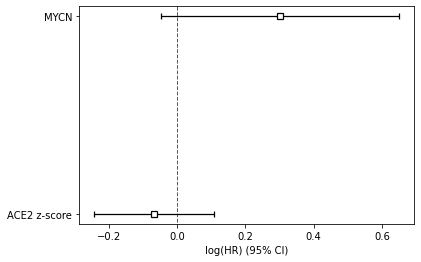

In [31]:
cph.plot()

In [18]:
#Not filtered
cph2 = CoxPHFitter()
cph2.fit(hazard_model_coded_df.dropna(),"EFS Time",event_col="Event Status")
cph2.print_summary()

/Users/brandonbergs/anaconda2/envs/v3_8/lib/python3.8/site-packages/lifelines/utils/__init__.py:1110: ConvergenceWarning: Column INSS Stage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Event Status'].astype(bool)
>>> print(df.loc[events, 'INSS Stage'].var())
>>> print(df.loc[~events, 'INSS Stage'].var())

A very low variance means that the column INSS Stage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/brandonbergs/anaconda2/envs/v3_8/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1575: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.977. This may imply non-unique solutions to the m

<lifelines.CoxPHFitter: fitted with 126 total observations, 60 right-censored observations>
             duration col = 'EFS Time'
                event col = 'Event Status'
      baseline estimation = breslow
   number of observations = 126
number of events observed = 66
   partial log-likelihood = -221.67
         time fit was run = 2021-02-05 02:30:01 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
Diagnosis Age (days)        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
INSS Stage                 14.36   1.72e+06    2715.32         -5307.57          5336.28                 0.00                  inf
MYCN                        0.37       1.45       0.35            -0.33             1.07                 0.72                 2.90
Ploidy                     -0.10       0.90       0.27            -0.63             0.42                 0.53                 1.53
Tumor Sample Histology     15.37   4.73e+06    4584.01         -8969.13          8999.86                 0.00                  inf
Neoplasm Histologic Grade -16.27       0.00    4584.01         -9000.76          8968.23                 0.00                  inf
MKI                        -0.18       0.83       0.20            -0.58             0.21                 0.56                 1.24
ACE2 z-score               -0.06       0.94       0.14            -0.33             0.21                 0.72                 1.23

                              z    p   -log2(p)
covariate                                      
Diagnosis Age (days)       0.42 0.68       0.56
INSS Stage                 0.01 1.00       0.01
MYCN                       1.04 0.30       1.75
Ploidy                    -0.39 0.70       0.51
Tumor Sample Histology     0.00 1.00       0.00
Neoplasm Histologic Grade -0.00 1.00       0.00
MKI                       -0.91 0.36       1.46
ACE2 z-score              -0.45 0.65       0.61
---
Concordance = 0.71
Partial AIC = 459.34
log-likelihood ratio test = 21.80 on 8 df
-log2(p) of ll-ratio test = 7.56

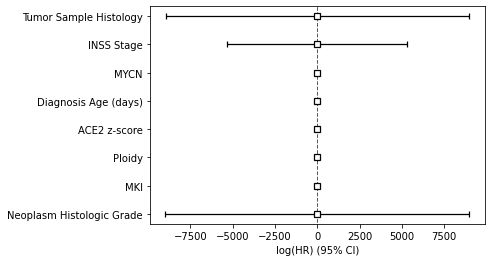

In [19]:
cph2.plot()